# OPTICS

For an additional analysis we choose optics, the main points of this algorithm is being able to tackle diversity in the density. Also a very nice addition is the possibility of avoiding the usage of $Eps$ given how the algorithm is made and it should somehow overcome the main diversity issue.

All these shoud be able to avoid the shortcomings of DBSCAN.

In [1]:
import datetime
from sklearn.cluster import OPTICS,DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from scipy.sparse import csr_matrix

RACES_PATH=path.join("..","dataset","engineered_races.csv")
races_df=pd.read_csv(RACES_PATH)

num_columns = [
            'points',
            'length',
            'climb_total',
            'profile',
            'startlist_quality',
            'position',
            'cyclist_age',
            'delta',
            'climbing_efficiency',
            'competitive_age',
            'difficulty',
            'convenience_score',
            'difficulty_score',
            'performance_index',
            'gain_ratio',
 ]
start_date='1980-01-01'
end_date='2000-01-01'
data_df=races_df.loc[ races_df['date'].between(start_date, end_date),num_columns ].drop_duplicates().astype('float64')
data_df

,points,length,climb_total,profile,startlist_quality,position,cyclist_age,delta,climbing_efficiency,competitive_age,difficulty,convenience_score,difficulty_score,performance_index,gain_ratio
426,50.0,8100.0,2330.469215,3.0,804.0,0.0,27.0,0.0,0.287712,27.0,9.528035e+04,0.003177,0.855043,0.400000,58.476618
427,50.0,8100.0,2330.469215,3.0,804.0,1.0,28.0,3.0,0.287712,28.0,6.620709e+04,0.004574,0.855043,0.454956,58.476618
428,50.0,8100.0,2330.469215,3.0,804.0,2.0,29.0,4.0,0.287712,29.0,4.997718e+04,0.006060,0.855043,0.452768,58.476618
429,50.0,8100.0,2330.469215,3.0,804.0,3.0,26.0,8.0,0.287712,26.0,4.515016e+04,0.006708,0.855043,0.084484,58.476618
430,50.0,8100.0,2330.469215,3.0,804.0,4.0,26.0,11.0,0.287712,26.0,3.008093e+05,0.001004,0.855043,0.448394,58.476618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588841,50.0,184000.0,2330.469215,3.0,568.0,4.0,25.0,0.0,0.012666,25.0,3.202739e+05,0.000943,1.377001,0.728640,36.310793
588842,50.0,184000.0,2330.469215,3.0,568.0,5.0,23.0,0.0,0.012666,23.0,2.895083e+06,0.000101,1.377001,0.474094,36.310793
588843,50.0,184000.0,2330.469215,3.0,568.0,6.0,28.0,0.0,0.012666,28.0,1.944353e+06,0.000152,1.377001,0.444019,36.310793
588844,50.0,184000.0,2330.469215,3.0,568.0,7.0,30.0,0.0,0.012666,30.0,1.349456e+06,0.000221,1.377001,0.414217,36.310793


In [2]:
from sklearn.preprocessing import StandardScaler

std_scaler=StandardScaler()

std_data=std_scaler.fit_transform(data_df)
#useful to estimatethe density of the dataset
maximum_distance=abs(std_data.max()-std_data.min()).sum().item()
average_concentration= std_data.shape[0]/maximum_distance

print(f"""
maximum distance={maximum_distance}
average concentration={average_concentration}
""")

std_data


maximum distance=53.592274850888515
average concentration=2655.0654995687487



array([[-0.94163857, -2.29220194,  0.0399313 , ..., -0.67851819,
         0.37651469, -0.2372891 ],
       [-0.94163857, -2.29220194,  0.0399313 , ..., -0.67851819,
         0.7048743 , -0.2372891 ],
       [-0.94163857, -2.29220194,  0.0399313 , ..., -0.67851819,
         0.69180526, -0.2372891 ],
       ...,
       [-0.94163857,  0.13132984,  0.0399313 , ...,  0.29713389,
         0.6395291 , -0.27674731],
       [-0.94163857,  0.13132984,  0.0399313 , ...,  0.29713389,
         0.46146344, -0.27674731],
       [-0.94163857,  0.13132984,  0.0399313 , ...,  0.29713389,
         2.25518909, -0.27674731]])

# 2010 to 2024 plot

So we need to setup the algorithm, i this case we want it to be able to run in reasonable amout of times we have to put a limit on the eps values available for this reason we fix eps at 10%. Given how the algorithms works its not necessary to set a value for eps but it is necessary to set one for the min samples, we apply the same reasoning here without havig to use the kneedle algorithm as in DBSCAN.

So first we take advtange of the algorithm and try a coarse grained approach to clustering.

In [3]:
import time
import itertools as it
from sklearn.metrics import silhouette_score,davies_bouldin_score

n_dim=std_data.shape[1]
n_size=std_data.shape[0]

min_sample_values=[
    2
    #testing by also weighting it with the dimensionality
#    int((n_size-1)*0.01*(1/n_dim)),
#    int((n_size-1)*0.02*(1/n_dim)),
#    int((n_size-1)*0.03*(1/n_dim)),
#    int((n_size-1)*0.04*(1/n_dim)),
#    int((n_size-1)*0.05*(1/n_dim)),
#    int((n_size-1)*0.1*(1/n_dim)),
]

xi_values=[
    0.05,
#    0.1,
#    0.2
]
results=[]

for min_sample_size,xi in it.product(min_sample_values,xi_values):
    start=time.time()
    optics=OPTICS(
        min_samples=2 if min_sample_size < 2 else min_sample_size,
        max_eps=maximum_distance*0.1,
        xi=xi,
        n_jobs=-1
    )
    end=time.time()
    optics.fit(std_data)
    labels=optics.labels_
    if not len(set(labels)) > 1:
        silhoutte_val= 'all labels equals'
        davies_bouldin_val= 'all labels equals'
    else:
        silhoutte_val=silhouette_score(std_data,labels)
        davies_bouldin_val=davies_bouldin_score(std_data,labels)
    
    reachability=optics.reachability_
    ordering=optics.ordering_
    core_distances= optics.core_distances_
    res={
            'min_samples':min_sample_size,
            'silhoutte_score':silhoutte_val,
            'davies_bouldin_score':davies_bouldin_val,
            'labels':labels,
            'reachability':reachability,
            'core_distances':core_distances,
            'ordering':ordering,
            'xi':xi,
            'time(s)':(end-start),
        }
    print(res)
    results.append(
        res
    )

results_df=pd.DataFrame(results)

: 

In [ ]:

for k in range(len(results)):
    results[k]['core_distances']=list(map(float,results[k]['core_distances']))
    results[k]['labels']=list(map(float,results[k]['labels']))
    results[k]['reachability']=list(map(float,results[k]['reachability']))
    results[k]['core_distances']=list(map(float,results[k]['core_distances']))
    results[k]['ordering']=list(map(float,results[k]['ordering']))
    results[k]['silhoutte_score']=float(results[k]['silhoutte_score'])
    results[k]['davies_bouldin_score']=float(results[k]['davies_bouldin_score'])
    results[k]['xi']=float(results[k]['xi'])

for k,v in results[0].items():
    print(k,type(v))

min_samples <class 'int'>
silhoutte_score <class 'float'>
davies_bouldin_score <class 'float'>
labels <class 'list'>
reachability <class 'list'>
core_distances <class 'list'>
ordering <class 'list'>
xi <class 'float'>
time(s) <class 'float'>


In [97]:
import json
with open('optics_results_2980to2000b.json','w') as f:
    json.dump(results,f )

In [56]:
top10_results=results_df[results_df['silhoutte_score']!='all labels equals'].sort_values(by='silhoutte_score',ascending=False).head(10)

top10_results

,min_samples,silhoutte_score,davies_bouldin_score,labels,reachability,core_distances,time(s)
3,211,0.801544,1.861952,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.413410263336307, 1.740016527164448, 1....","[1.787429773529056, 1.92280716952867, 2.369388...",0.000016
4,211,0.801544,1.861952,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.413410263336307, 1.740016527164448, 1....","[1.787429773529056, 1.92280716952867, 2.369388...",0.000030
5,211,0.801544,1.861952,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.413410263336307, 1.740016527164448, 1....","[1.787429773529056, 1.92280716952867, 2.369388...",0.000017
6,317,0.800078,1.901963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.733216946721319, 1.837569921647756, 1....","[1.974289934520991, 2.137637186663265, 2.61703...",0.000008
7,317,0.800078,1.901963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.733216946721319, 1.837569921647756, 1....","[1.974289934520991, 2.137637186663265, 2.61703...",0.000009
8,317,0.800078,1.901963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.733216946721319, 1.837569921647756, 1....","[1.974289934520991, 2.137637186663265, 2.61703...",0.000008
9,423,0.798521,1.937091,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.961712450846558, 1.948578790305557, 1....","[2.142167689940046, 2.281491079575051, 2.82560...",0.000011
10,423,0.798521,1.937091,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.961712450846558, 1.948578790305557, 1....","[2.142167689940046, 2.281491079575051, 2.82560...",0.000007
11,423,0.798521,1.937091,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.961712450846558, 1.948578790305557, 1....","[2.142167689940046, 2.281491079575051, 2.82560...",0.000010
14,529,0.796925,1.966726,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 2.151179964575056, 2.064933795097817, 2....","[2.280990230908138, 2.394717277164706, 2.98455...",0.000022


In [38]:
import matplotlib.pyplot as plt
import numpy as np

best_params=top10_results.iloc[0]
print(f"""
best params 
{best_params}
""")
best_optics=OPTICS(
    min_samples= int(2 if best_params['min_samples'] < 2 else best_params['min_samples']),
    max_eps=maximum_distance*0.1,
    n_jobs=-1
)
best_optics.fit(std_data)


best params 
min_samples                                                           211
silhoutte_score                                                  0.801544
davies_bouldin_score                                             1.861952
labels                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
reachability            [inf, 1.413410263336307, 1.740016527164448, 1....
core_distances          [1.787429773529056, 1.92280716952867, 2.369388...
time(s)                                                          0.000016
Name: 3, dtype: object



KeyboardInterrupt: 

In [98]:
import json
results=None
with open('optics_results_2010to2024.json','r') as f:
    results=json.load(f)
results_df=pd.DataFrame(results).sort_values(by='silhoutte_score')

best_optics=results_df.iloc[0]
best_optics

min_samples                                                           175
silhoutte_score                                                  0.589596
davies_bouldin_score                                             0.464626
labels                  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
reachability            [inf, 1.26691557028695, 1.196999249847139, 1.1...
core_distances          [1.355215256046933, 1.873028776971962, 1.27742...
ordering                [0.0, 6.0, 7.0, 2.0, 3.0, 9.0, 15.0, 11.0, 13....
xi                                                                   0.05
time(s)                                                          0.000007
Name: 0, dtype: object

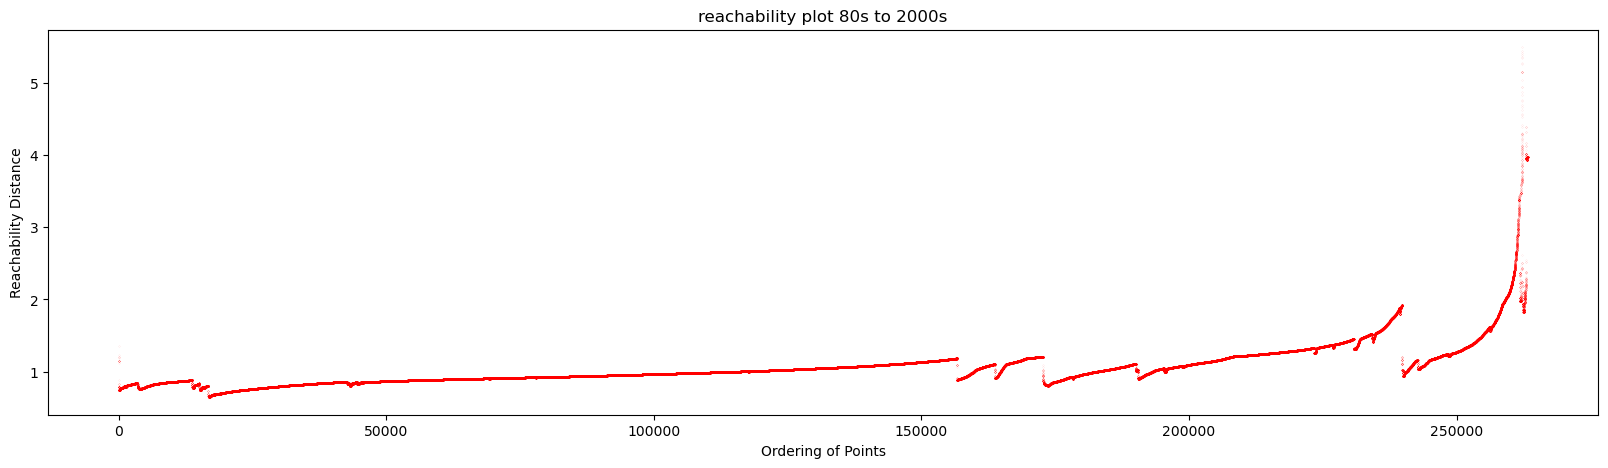

In [99]:
labels=np.array(best_optics['labels'])
reachability=np.array(best_optics['reachability'])
ordering=np.array(best_optics['ordering'],dtype=int)
core_distances= np.array(best_optics['core_distances'])

def reachability_plot(title,reachability,ordering):
    plt.figure(figsize=(20,5))
    plt.title(f'reachability plot {title}')
    plt.fill_between(np.arange(len(reachability)), reachability[ordering],markersize=0.1)
    plt.ylabel("Reachability Distance")
    plt.xlabel("Ordering of Points")
    plt.show()

def cluster_visualization(title,labels):
    # 2. Cluster visualization
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    plt.title(f"Clustered Data for {title}")
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Black for noise
        class_member_mask = (labels == k)
        xy = std_data[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
    plt.show()

reachability_plot("80s to 2000s",reachability,ordering)
#cluster_visualization("80s to 2000s",labels)

# Cyclists clustering


In [105]:
import datetime
from sklearn.cluster import OPTICS,DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from scipy.sparse import csr_matrix

CYCLISTS_PATH=path.join("..","dataset","cyclists_final_enhanced.csv")
cyclists_df=pd.read_csv(CYCLISTS_PATH)
num_columns = ['bmi', 'height', 'weight', 'birth_year', 'avg_pos', 'career_duration(races)', 'debut_year', 'career_duration(days)', 'career_points']
data_df = cyclists_df[num_columns]

data_df

,bmi,height,weight,birth_year,avg_pos,career_duration(races),debut_year,career_duration(days),career_points
0,21.329438,185,73.0,1964,110.000000,1.0,1989.0,1.0,80.0
1,22.340297,182,74.0,1965,63.545045,222.0,1988.0,3492.0,26105.0
2,19.316369,189,69.0,1996,87.693878,49.0,2022.0,519.0,4425.0
3,21.158854,192,78.0,1995,83.242236,161.0,2018.0,1982.0,17205.0
4,18.809206,171,55.0,1997,68.000000,48.0,2021.0,721.0,3085.0
...,...,...,...,...,...,...,...,...,...
6090,19.350208,179,62.0,1966,10.000000,1.0,1993.0,1.0,80.0
6091,21.220009,188,75.0,1998,84.576923,26.0,2020.0,1140.0,2410.0
6092,20.451146,181,67.0,1973,106.500000,12.0,1997.0,311.0,955.0
6093,20.069204,170,58.0,1985,71.929204,113.0,2009.0,1849.0,8920.0


In [106]:
std_scaler=StandardScaler()

std_data=std_scaler.fit_transform(data_df)

In [121]:
import time
import itertools as it
from sklearn.metrics import silhouette_score,davies_bouldin_score

n_dim=std_data.shape[1]
n_size=std_data.shape[0]

min_sample_values=[
    2
    #testing by also weighting it with the dimensionality
#    int((n_size-1)*0.01*(1/n_dim)),
#    int((n_size-1)*0.02*(1/n_dim)),
#    int((n_size-1)*0.03*(1/n_dim)),
#    int((n_size-1)*0.04*(1/n_dim)),
#    int((n_size-1)*0.05*(1/n_dim)),
#    int((n_size-1)*0.1*(1/n_dim)),
]

xi_values=[
    0.05,
#    0.1,
#    0.2
]
results=[]

for min_sample_size,xi in it.product(min_sample_values,xi_values):
    start=time.time()
    optics=OPTICS(
        min_samples=2 if min_sample_size < 2 else min_sample_size,
        max_eps=maximum_distance*0.1,
        xi=xi,
        n_jobs=-1
    )
    end=time.time()
    optics.fit(std_data)
    labels=optics.labels_
    if not len(set(labels)) > 1:
        silhoutte_val= 'all labels equals'
        davies_bouldin_val= 'all labels equals'
    else:
        silhoutte_val=silhouette_score(std_data,labels)
        davies_bouldin_val=davies_bouldin_score(std_data,labels)
    
    reachability=optics.reachability_
    ordering=optics.ordering_
    core_distances= optics.core_distances_
    res={
            'min_samples':min_sample_size,
            'silhoutte_score':silhoutte_val,
            'davies_bouldin_score':davies_bouldin_val,
            'labels':labels,
            'reachability':reachability,
            'core_distances':core_distances,
            'ordering':ordering,
            'xi':xi,
            'time(s)':(end-start),
        }
    print(res)
    results.append(
        res
    )

results_df=pd.DataFrame(results)

{'min_samples': 2, 'silhoutte_score': -0.14572817669853536, 'davies_bouldin_score': 1.2787262320737052, 'labels': array([  0,  -1,  -1, ...,  10,  -1, 377]), 'reachability': array([       inf, 0.66308909, 0.54572668, ..., 0.41581077, 0.71168513,
       0.39596249]), 'core_distances': array([0.2541162 , 0.66308909, 0.53822916, ..., 0.41581077, 0.70678332,
       0.39596249]), 'ordering': array([   0, 2624, 2617, ..., 3327, 1604, 5409]), 'xi': 0.05, 'time(s)': 0.0010251998901367188}


In [122]:
def reachability_plot(title,reachability,ordering):
    plt.figure(figsize=(20,5))
    plt.title(f'reachability plot {title}')
    plt.fill_between(np.arange(len(reachability)), reachability[ordering],alpha=0.7)
    plt.ylabel("Reachability Distance")
    plt.xlabel("Ordering of Points")
    plt.xlim(0,len(reachability))
    plt.ylim(0,max( reachability[ordering][1:]))
    plt.show()
best_optics_params=results_df[results_df['silhoutte_score']!='all labels equals'].sort_values(by='silhoutte_score',ascending=False).iloc[0]

best_optics_params

min_samples                                                             2
silhoutte_score                                                 -0.145728
davies_bouldin_score                                             1.278726
labels                  [0, -1, -1, 777, 793, 61, 914, -1, -1, 733, -1...
reachability            [inf, 0.663089085220439, 0.545726683348324, 0....
core_distances          [0.254116201462092, 0.663089085220439, 0.53822...
ordering                [0, 2624, 2617, 3275, 4946, 3975, 4703, 5130, ...
xi                                                                   0.05
time(s)                                                          0.001025
Name: 0, dtype: object

# Cyclists reachability plot

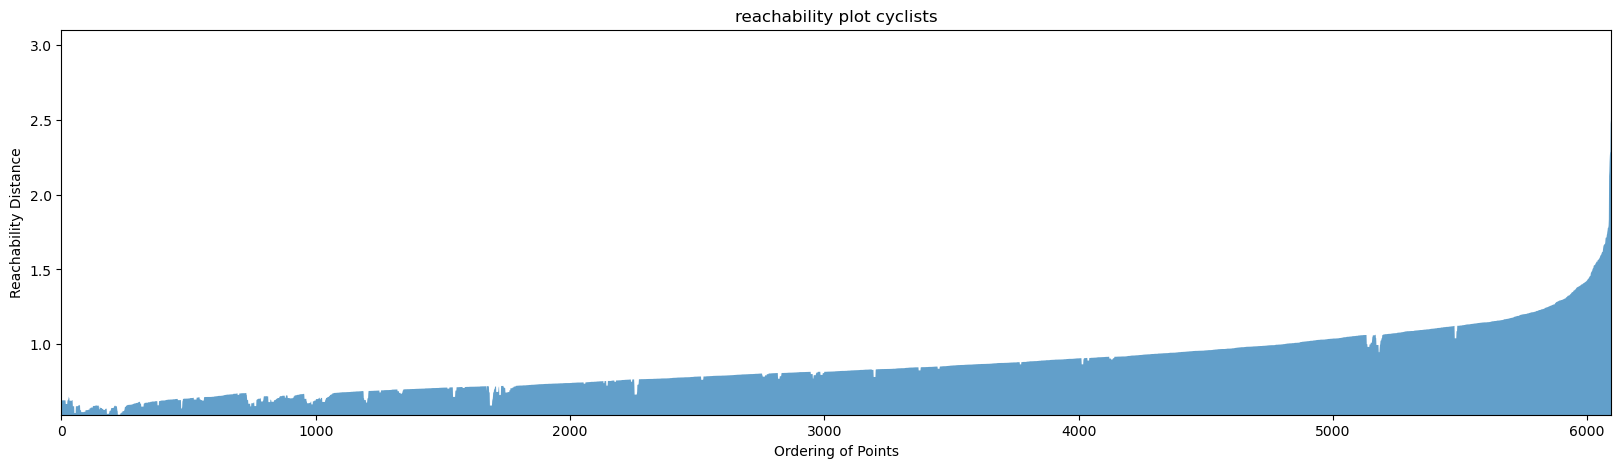

In [119]:
reachability=best_optics_params['reachability']
ordering=best_optics_params['ordering']
reachability_plot("cyclists",reachability=reachability,ordering=ordering)